### Read Data

In [1]:
# Import Libraries
import pandas as pd
import ast
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [2]:


# Read data from CSV
file_path = '/kaggle/input/data-model2/data_model2.csv'
df = pd.read_csv(file_path)

In [3]:
# Convert string literals to Python lists
df['statement'] = df['statement'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Join lists into sentences
df['statement'] = df['statement'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


In [4]:
df.head()

,Unnamed: 0,statement,status
0,0,oh gosh,2
1,1,trouble sleep confused mind restless heart tune,2
2,2,wrong back dear forward doubt stay restless re...,2
3,3,shift focus something else still worry,2
4,4,restless restless month boy mean,2


### Resampling for more balance data

In [5]:
from sklearn.utils import resample
df_sample = df.sample(n=20000,random_state=2024)
majority_size = len(df_sample[df_sample['status']==0])

def resampling(df):
  minority_resample = resample(df,replace=True, n_samples=majority_size,random_state=22)
  return minority_resample

In [6]:
df_sample_1 = resampling(df_sample[df_sample['status']==1])
df_sample_2 = resampling(df_sample[df_sample['status']==2])
df_sample_3 = resampling(df_sample[df_sample['status']==3])
df_sample_4 = resampling(df_sample[df_sample['status']==4])
df_sample_5 = resampling(df_sample[df_sample['status']==5])

df_new =pd.concat([df_sample[df_sample['status']==0],df_sample_1,df_sample_2,df_sample_3,df_sample_4,df_sample_5], axis=0).reset_index(drop=True)
df_new['status'].value_counts()

status
0    7710
1    7710
2    7710
3    7710
4    7710
5    7710
Name: count, dtype: int64

In [7]:
df_new.head()

,Unnamed: 0,statement,status
0,42422,real n twitter hate u,0
1,4204,two,0
2,2180,love matter far near determine mine love death...,0
3,6269,father s obligation feed clothe mother good way,0
4,5093,mutual let we,0


## Modelling

In [8]:
pip install gensim --no-deps


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint



### Tokenization with keras

In [10]:
# Configuration
EMBEDDING_DIM = 100  # Dimension of word embeddings
MAX_NUM_WORDS = 10000  # Maximum number of unique words
MAX_SEQUENCE_LENGTH = 200  # Fixed sequence length for all input data



# Tokenizer: Train and convert text to sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True)  # Limit vocabulary size and convert to lowercase
tokenizer.fit_on_texts(df_new['statement'])  # Learn the vocabulary from the text data
X = tokenizer.texts_to_sequences(df_new['statement'])  # Convert text to numerical sequences

# Pad sequences to ensure uniform length
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # Add padding at the end of sequences


In [11]:
import pickle

# Save the tokenizer to a .pkl file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer has been saved to tokenizer.pkl")


Tokenizer has been saved to tokenizer.pkl


In [12]:
df_new.head(20)

,Unnamed: 0,statement,status
0,42422,real n twitter hate u,0
1,4204,two,0
2,2180,love matter far near determine mine love death...,0
3,6269,father s obligation feed clothe mother good way,0
4,5093,mutual let we,0
5,5456,come want check k file turn u,0
6,4154,al ham h oh god touch,0
7,33037,yes land reporter army band,0
8,42350,earthquake ha make sad saw pic news terrible,0
9,42535,yeah application run every minute add conflict ti,0


### Convert label to one-hot encoding

In [13]:
# Convert labels to one-hot encoding
y = pd.get_dummies(df_new['status']).values  # Transform class labels into a binary matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# `test_size=0.3` allocates 30% of the data for testing, 70% for training
# `random_state=42` ensures reproducibility of the split



### Word Embedding

In [14]:
# Download and load pre-trained GloVe embeddings (100 dimensions)
glove_gensim = api.load('glove-wiki-gigaword-100')

# Create a weight matrix for the embedding layer
gensim_weight_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))  # Initialize with zeros

# Populate the weight matrix with GloVe vectors for words in the tokenizer's vocabulary
for word, index in tokenizer.word_index.items():
    if index < MAX_NUM_WORDS:  # Ensure the index is within the specified maximum word limit
        if word in glove_gensim.index_to_key:  # Check if the word exists in the GloVe vocabulary
            gensim_weight_matrix[index] = glove_gensim[word]  # Assign the GloVe vector
        else:
            gensim_weight_matrix[index] = np.zeros(EMBEDDING_DIM)  # Assign a zero vector if the word is not found


[==================================================] 100.0% 128.1/128.1MB downloaded


### Build the Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Input, Bidirectional

# Build the model
model = Sequential()

# Add Input layer
model.add(Input(shape=(X.shape[1],)))  # Sequence length: 200

# Embedding Layer
model.add(Embedding(input_dim=MAX_NUM_WORDS,       # Number of words in the tokenizer
                    output_dim=EMBEDDING_DIM,     # Embedding dimensions (e.g., 100)
                    weights=[gensim_weight_matrix],  # Pre-trained GloVe embedding matrix
                    trainable=False))             # Fine-tuning allowed (weights can be updated)

# Bidirectional GRU Layer 1
model.add(Bidirectional(GRU(100, return_sequences=True)))  # First Bidirectional GRU layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# GRU Layer 2 (normal GRU)
model.add(GRU(100, return_sequences=True)) 
model.add(Dropout(0.2))  

# Bidirectional GRU Layer 3
model.add(Bidirectional(GRU(100, return_sequences=True)))  
model.add(Dropout(0.2))  

# GRU Layer 4 (normal GRU)
model.add(GRU(100, return_sequences=False))  # Fourth GRU layer, not returning sequences
model.add(Dropout(0.2))  #

# Fully Connected Output Layer
model.add(Dense(64, activation='relu'))  
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Output Layer
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 200)       │       121,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 200, 100)       │        90,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 200)       │       121,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        90,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,430,454 (5.46 MB)

 Trainable params: 430,454 (1.64 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [16]:
from tensorflow.keras.models import load_model

# EarlyStopping and ModelCheckpoint for saving weights
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[es, mc]
)

# After training, load the best weights
model.load_weights('best_model.weights.h5')
print("Best weights loaded from best_model.weights.h5")

# Save the full model to .keras format
model.save('best_model.keras')
print("Full model saved as best_model.keras")

# Convert the .keras file to .h5
model.save('best_model.h5', save_format='h5')
print("Full model saved as best_model.h5")


Epoch 1/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1736 - loss: 1.7864
Epoch 1: val_accuracy improved from -inf to 0.20147, saving model to best_model.weights.h5
506/506 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.1736 - loss: 1.7864 - val_accuracy: 0.2015 - val_loss: 1.7611
Epoch 2/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1869 - loss: 1.7583
Epoch 2: val_accuracy improved from 0.20147 to 0.27540, saving model to best_model.weights.h5
506/506 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.1870 - loss: 1.7583 - val_accuracy: 0.2754 - val_loss: 1.6434
Epoch 3/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3436 - loss: 1.5155
Epoch 3: val_accuracy improved from 0.27540 to 0.70565, saving model to best_model.weights.h5
506/506 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.3439 - loss: 1.5151 - val_accuracy: 0.7056 - val_loss: 0.8290
Epoch 4/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7247 - loss: 0.7993
Epoch 4: val_acc

### Train the Model

In [17]:
from tensorflow.keras.models import load_model

# EarlyStopping and ModelCheckpoint for saving weights
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[es, mc]
)

# After training, load the best weights
model.load_weights('best_model.weights.h5')
print("Best weights loaded from best_model.weights.h5")

# Save the full model to .keras format
model.save('best_model.keras')
print("Full model saved as best_model.keras")

# Convert the .keras file to .h5
model.save('best_model.h5', save_format='h5')
print("Full model saved as best_model.h5")


Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9943 - loss: 0.0206
Epoch 1: val_accuracy improved from -inf to 0.96433, saving model to best_model.weights.h5
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.9943 - loss: 0.0206 - val_accuracy: 0.9643 - val_loss: 0.1995
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9967 - loss: 0.0134
Epoch 2: val_accuracy did not improve from 0.96433
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.9967 - loss: 0.0133 - val_accuracy: 0.9608 - val_loss: 0.2425
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9962 - loss: 0.0131
Epoch 3: val_accuracy improved from 0.96433 to 0.96757, saving model to best_model.weights.h5
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.9962 - loss: 0.0131 - val_accuracy: 0.9676 - val_loss: 0.1999
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9976 - loss: 0.0108
Epoch 4: val_accuracy did not improve from 0.96757
253/

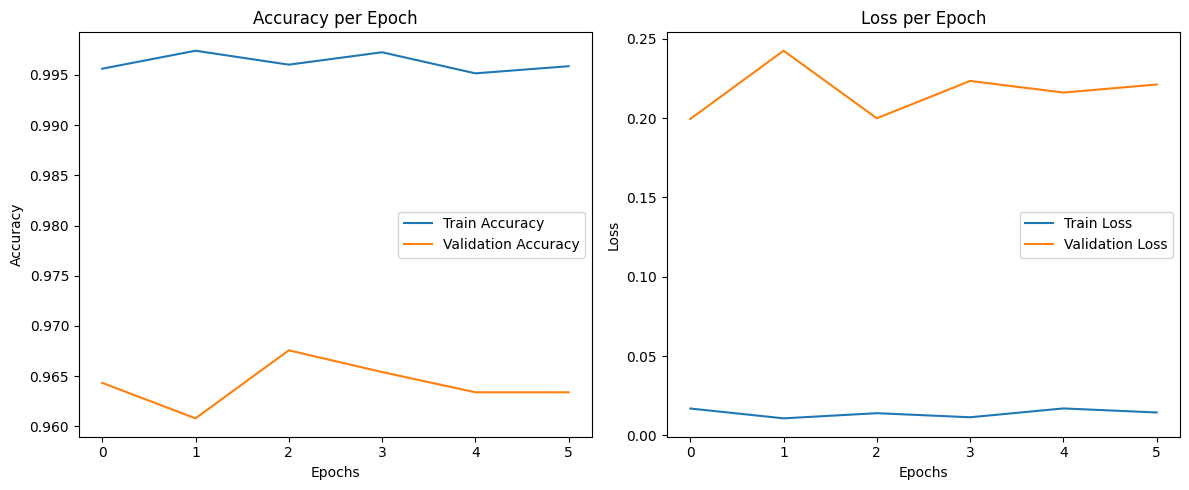

In [18]:
import matplotlib.pyplot as plt

# Plot for accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
plt.title('Accuracy per Epoch')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Display legend

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')  # Training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss
plt.title('Loss per Epoch')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Display legend

# Display the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()  # Show the plots

In [19]:
# from sklearn.metrics import classification_report

# # Get model predictions
# y_pred = model.predict(X_test)

# # Convert predictions and labels from one-hot encoding to integer labels
# y_pred_labels = np.argmax(y_pred, axis=1)
# y_test_labels = np.argmax(y_test, axis=1)

# # Generate the classification report
# report = classification_report(y_test_labels, y_pred_labels, target_names=df['status'].unique())

# # Print the classification report
# print(report)

In [20]:

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

434/434 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9687 - loss: 0.1990
Test Loss: 0.19993090629577637
Test Accuracy: 0.9675745964050293


### Model Evaluation